In [1]:
from plotting_masses import *

In [2]:
event_data, classifier = train_electron_classifier(None, 'psiK_1000.root', True)

[18:03:51] WARNING: /private/var/folders/h4/xn394t6140g90b5dhr7hl1n40000gn/T/pip-install-1b5gzcgs/xgboost_e8996f132b654debbc7a5a7211bb9190/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Electron Classifier Training Accuracy: 1.0
Electron Classifier Validation Accuracy: 0.8139773895169579


/Users/will/Documents/msci-brem-reconstruction/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [3]:
# look at scaling ratios
# seperate electrons by number of photons
# graph with reconstructed vs false brem photons
# adding true photons - idealised energy energy plot

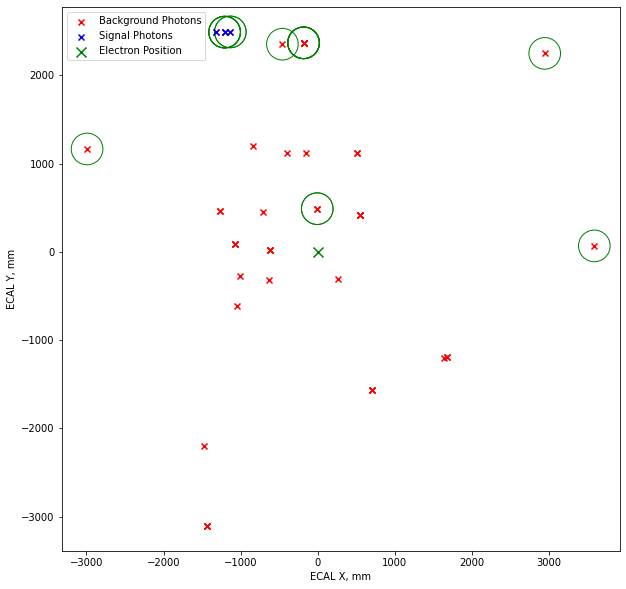

In [4]:
import random
np.random.seed(10)
d = event_data[-1]
data_slice = electron_data_slice(
                    d.event_number,
                    d.electron_plus_momentum,
                    d.electron_plus_position,
                    d.brem_plus_momenta,
                    d.brem_plus_positions,
                    d.brem_plus_ovz,
                    True,
                    label=1
)
sampled_event_data: List[EventData] = list(np.random.choice(event_data, size = 5))
false_data_slices = pd.concat([
    electron_data_slice(di.event_number,
    d.electron_plus_momentum,
    d.electron_plus_position,
    di.brem_plus_momenta,
    di.brem_plus_positions,
    di.brem_plus_ovz,
    True,
    label=1)
for di in sampled_event_data])


other_brem_photons = list(chain.from_iterable([
    [brem_pos for brem_pos, ovz in zip(di.brem_plus_positions, di.brem_plus_ovz) if ovz < 5000] for di in sampled_event_data
]))

accuracte_brem_photons = [brem_pos for brem_pos, ovz in zip(d.brem_plus_positions, d.brem_plus_ovz) if ovz < 5000]
false_data = false_data_slices.drop(["label", "id"], axis=1).to_numpy()



predictions: List[bool] = classifier.predict(false_data) == 1
other_x = [pos.x for pos in other_brem_photons]
other_y = [pos.y for pos in other_brem_photons]
this_x = [pos.x for pos in accuracte_brem_photons]
this_y = [pos.y for pos in accuracte_brem_photons]

true_x = []
true_y = []
for pred, pos in zip(predictions, other_brem_photons):
    if np.isnan(pos.x):
        continue
    if pred:
        true_x.append(pos.x)
        true_y.append(pos.y)
data_slice = data_slice.drop(["label", "id"], axis=1).to_numpy()
predictions: List[bool] = classifier.predict(data_slice) == 1
for pred, pos in zip(predictions, accuracte_brem_photons):
    if np.isnan(pos.x):
        continue
    if pred:
        true_x.append(pos.x)
        true_y.append(pos.y)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.scatter(other_x, other_y, color='r', marker='x', label="Background Photons")
ax.scatter(true_x, true_y, s=1000, facecolors='none', edgecolors="g")
ax.scatter(this_x, this_y, color='b', marker='x', label="Signal Photons")
ax.scatter(d.electron_plus_position.x, d.electron_plus_position.y, s=100, color='g', marker='x', label="Electron Position")
ax.legend()
ax.set_xlabel("ECAL X, mm")
ax.set_ylabel("ECAL Y, mm")
plt.savefig("e_targets.png")
plt.show()
    